# Nuclei segmentation

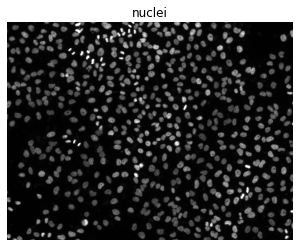

In [1]:
import tifffile
import matplotlib.pyplot as plt

# We start loading the image
img = tifffile.imread('../data/nuclei.tif')

# Let's display the image that we just loaded
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('nuclei')
plt.show()

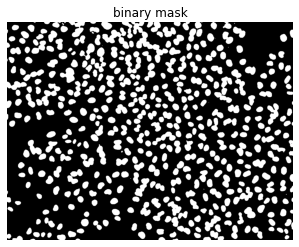

In [2]:
import numpy as np
from scipy import ndimage, misc

# Apply a median filter to the image
mask = ndimage.median_filter(img, size=5)

# Compute a threshold based on the background of the image
m0 = np.median(mask)
s0 = 1.48 * np.median(np.abs(mask - m0))
threshold = m0 + 3 * s0
mask = mask > threshold

# display the mask
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('binary mask')
plt.show()

Elapsed time: 1.05 s


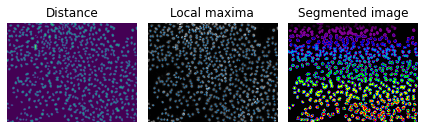

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import measure
from timeit import default_timer as timer

tic = timer()

# Compute the distance where mask is True to the closest point where it is False
distance = ndi.distance_transform_edt(mask)

# Extract local maxima from the distance
coords = peak_local_max(distance, min_distance=10)
peak = np.zeros(distance.shape, dtype=bool)
peak[tuple(coords.T)] = True
peak = np.logical_and(peak, mask)

# Define markers by finding connected component in the image
markers = measure.label(peak, background=0)

# Use the watershed with the distance function as priority map 
# and markers as seeds.
labels = watershed(-distance, markers, mask=mask)

# We can now display the 3 steps used to
fig, ax = plt.subplots(1, 3)
ax[0].imshow(distance)
ax[0].set_title('Distance')

ax[1].imshow(img,cmap='gray')
ax[1].plot(coords[:,1], coords[:,0], '.', markersize=1)
ax[1].set_title('Local maxima')

ax[2].imshow(labels,cmap='nipy_spectral')
ax[2].set_title('Segmented image')
for a in ax:
    a.set_axis_off()
fig.tight_layout()

# Display elapsed time for this step
etime = timer() - tic
print(f"Elapsed time: {etime:.2f} s")


Let's display now some information on the labelled regions. We can use a pandas frame to manipulate the result.

In [4]:
import pandas as pd
props = measure.regionprops_table(labels, img, properties=('area', 'mean_intensity'))
df = pd.DataFrame(props)
df.head()

,area,mean_intensity
0,779,128.937099
1,706,78.589235
2,749,76.610147
3,1357,117.840088
4,776,101.650773


Text(0, 0.5, 'Mean intensity')

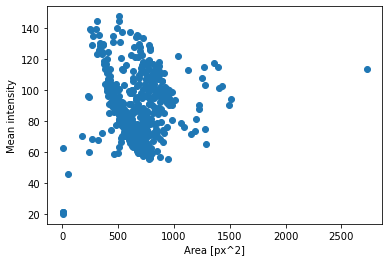

In [5]:
plt.scatter(df['area'],df['mean_intensity'])
plt.xlabel('Area [px^2]')
plt.ylabel('Mean intensity')